In [77]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from importlib import reload 

#add simulator to a path
sys.path.append('Simulator/')


import noise_models as nm

reload(nm)
%load_ext autoreload
%autoreload 2   



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parameters

In [174]:
BITS_PER_REPETITIONS = 1  #Number of algorithm run between the estimations
REPETITIONS = 100       #Repetition

SHOT_TIME = 5*1e3   #Time of shot in ns
QUBIT_FREQ = 15 #MHz 
DIFFUSE_PROB = True #Should I diffuse mu and sigma between shots?

# TODO: use non-ideal parameters of estimation
ALPHA = 0
BETA = 1
T2 = 10

SIGMA = 5

DTAU = 0.01

### Declaration of functions

In [206]:
def likelihood(x, noise, tau, df):
    tau = tau
    dt = tau/int(tau/DTAU)
    phi = (QUBIT_FREQ+df)*tau + np.sum([noise.update(dt) * dt for i in range(int(tau/DTAU))])
    return 1/2 + x/2*np.cos(2*np.pi*phi)

def normal_dist(x, mu, sigma):
    return np.exp(-1/2 * (x - mu)**2 / sigma**2)/np.sum(np.exp(-1/2 * (x - mu)**2 / sigma**2))

def prob_update(x, mu, std, t):
    denom = 1 + x*ALPHA
    m1 = (mu*(1+ALPHA*x) - x*BETA*np.exp(-t/T2 - 2*std**2*t**2*np.pi**2)*std**2*t*2*np.pi)/denom
    exp_arg = (-2.0*t/T2-4.0*std**2*t**2*np.pi**2)
    
    std = np.sqrt( std**2*( 1.0 - 4.0*std**2*t**2*np.exp(exp_arg)*np.pi**2*BETA/(1.0+x*ALPHA)**2 ))

    return m1, std

def diffuse_mu_std(mu, std, noise, adaptive = False, std0 = SIGMA, nshots = 1):
    #TODO: add evolution of mu
    a,b,c, = noise.abc
    if adaptive:
        #std = np.sqrt(a*np.log(np.exp(std**2/a -c)+b*(nshots))+c)
        std = np.sqrt(2**2 - (2**2-std**2)*np.exp(-2*nshots/5))
    else:
        std = std0
    mu = mu
    return mu, std

def estimate_cycle(noise, mus, std, N_SHOTS, SHOT_TIME,kappa, diffuse_prob = True):
    dmu_est = []
    stds = []
    xis = []
    dmu = 0 
    for k in range(N_SHOTS):
        dmu, std = estimate_shot(noise, dmu, std, get_tau(std), 
                                get_df(std,QUBIT_FREQ+dmu)-kappa*mus.filtered[-1])
        noise.update(SHOT_TIME)    
        stds.append(std)
        xis.append(noise.x)
        
        '''
        if diffuse_prob:
            mu, std = diffuse_mu_std(mus.filtered[-1], std, noise)
            mus.filtered[-1] = mu
        '''
    return dmu, stds, xis

def estimate_shot(noise, dmu, std, tau, df, rng_shot = np.random.default_rng()):
    p = likelihood(1, noise, tau, df)
    x = 2 * np.random.choice(2, p = (1-p,p))-1
    dmu, std = prob_update(x, dmu + QUBIT_FREQ, std, tau) 
    return dmu - QUBIT_FREQ, std



def get_df(sig, mu):
    # such that 2*pi*(mu+df)*tau = pi/2 + n pi, in case of which p(0) = p(1)
    # tau = 1/n/sig/2
    # df = n*sig
    return 1/4/get_tau(sig) - mu

def get_tau(sig):
    # such that 2pi sig*tau = pi, and width of the filter is sig
    return 1/sig/4

def get_bit(mu, noise, t,kappa, update_noise = True):
    om = noise.x + QUBIT_FREQ - kappa*mu  
    prob = (1 + np.cos(2*np.pi*om*t))/2
    if update_noise:
        noise.update(SHOT_TIME)
    return np.random.choice([1,0], p = [prob, 1-prob])

### Main program

dupa


/Users/krzywdaja/Documents/obsedian_test/Brain2/Science/Projects/overf-noise-extrapolation/Simulator/noise_models.py:281: RuntimeWarning: invalid value encountered in log
  return a*np.log(b*x)+c
/Users/krzywdaja/Documents/obsedian_test/Brain2/Science/Projects/overf-noise-extrapolation/Simulator/noise_models.py:299: RuntimeWarning: divide by zero encountered in divide
  ax[2].plot(f,(1/f)*f[-1])


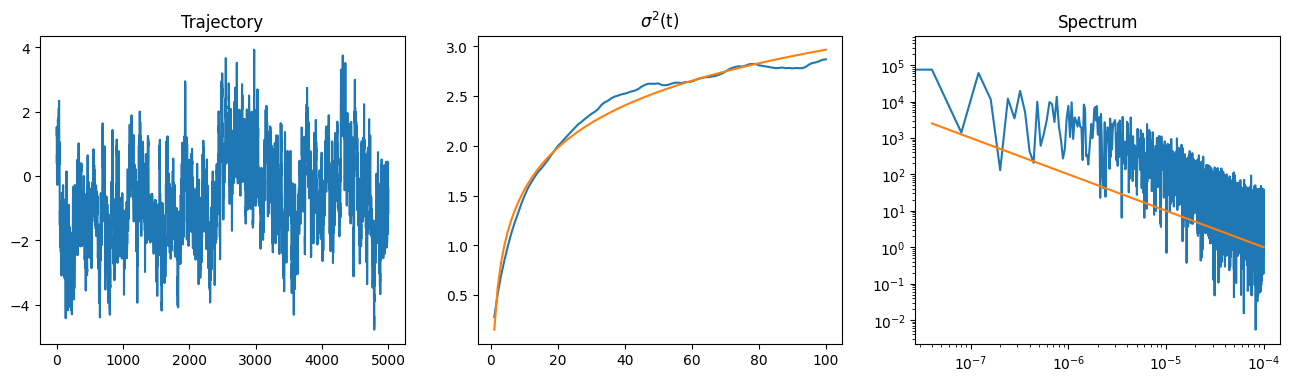

In [207]:
# Noise definition
ommin = 1/1e9
ommax = 1/1e4
N_FLUCTUATORS = 25
noise = nm.Over_f_noise(n_fluctuators = N_FLUCTUATORS, S1  = 0.4,
                        couplings_dispersion = 1e-99, 
                        ommax = ommax , 
                        ommin = ommin, 
                        om0 = 0,
                        fluctuator_class = nm.OrnsteinUhlenbeck)

noise.get_abc(SHOT_TIME)  #get the adaptive prior


In [209]:
std0s = [2,3]
shots = [3,5]



bit_times = np.linspace(0,0.4,31)

bits_res = np.zeros((2,len(std0s),len(shots),REPETITIONS,len(bit_times) ))
om_real = np.zeros((len(std0s),len(shots),(REPETITIONS)*len(bit_times)+1 ))
om_est = np.zeros((len(std0s),len(shots),(REPETITIONS)*len(bit_times)+1 ))
sigs_res = np.zeros((len(std0s),len(shots),(REPETITIONS)*len(bit_times)+1 ))

for n0,std0 in enumerate(std0s):
    print(n0)
    for l0,n in enumerate(shots):
        datan = []
        mus = Filter(1)

        mus, sigs, xis, bits, bits_noest = run_experiment(noise, sig0 = 2, mus = mus, 
                            bit_times = bit_times, Nshots =  n, adaptive = False, std0 = std0)
        om_real[n0,l0,:] = xis
        om_est[n0,l0,:] = mus.filtered
        bits_res[0,n0,l0,:,:] = bits[:,:,0]
        bits_res[1,n0,l0,:,:] = bits_noest[:,:,0]
        sigs_res[n0,l0,:] = sigs  

0
0.0
0.0
0.0
1
0.0
0.0
0.0


In [210]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

(0.0, 20.0)

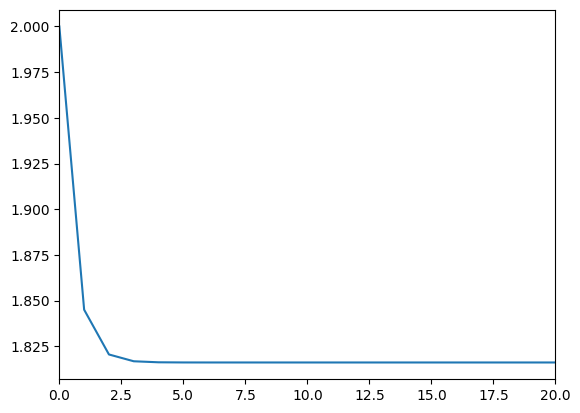

In [211]:
plt.plot(sigs_res[1,1])
plt.xlim(0,20)

IndexError: index 2 is out of bounds for axis 0 with size 2

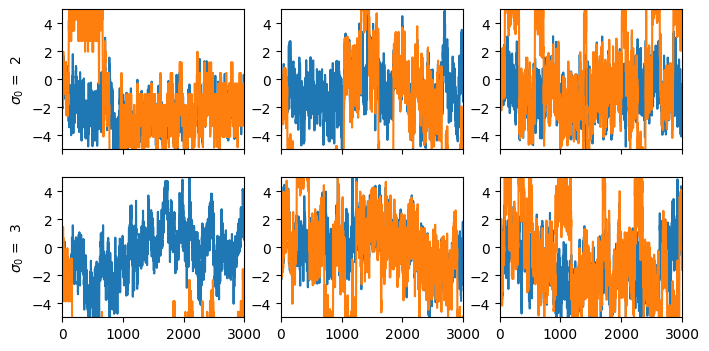

In [212]:
fig, ax = plt.subplots(len(std0s),len(shots),figsize=(8,4), sharex=True)
for i in range(len(std0s)):
    for j in range(len(shots)):
                ax[i,j].plot(om_real[i][j])
                ax[i,j].plot(om_est[i][j], label = "raw", alpha=1)
                #ax[i,j].plot(moving_average(om_est[i,j],10), label = "sigma")
                #ax[i].plot(data[i][1], label = str(Ns[i]))
                #ax[i].text(0.02, 0.75, 'L = ' + str(Ns[i]), fontsize=12, transform=ax[i].transAxes)
                ax[i,j].set_ylim(-5,5) 
                ax[i,j].set_xlim(0,3000)


for k in range(3):
    ax[k,0].set_ylabel(r'$\sigma_0$ =  '+str(std0s[k]))


for k in range(2):
    if k==0:
        ax[0,k].set_title('Shots = '+str(shots[k]))
    else:
        ax[0,k].set_title('Shots = '+str(shots[k]))
#ax[0].set_xlim(0,3000)
#ax[0].set_title('Nshots = '+str(N_SHOTS))   

bx = ax[1,1].twinx()
bx.set_yticks([])
bx.plot([],[],label = "noise")

bx.plot([],[],label = "estimated")
bx.legend(frameon = False, ncol=2, loc = 'lower left', fontsize = 6)

fig.suptitle(r"$\sigma_0 ="+str(SIGMA)+"$", fontsize=10)

Text(0.5, 0.98, 'Corrected $\\sigma_0 =5$')

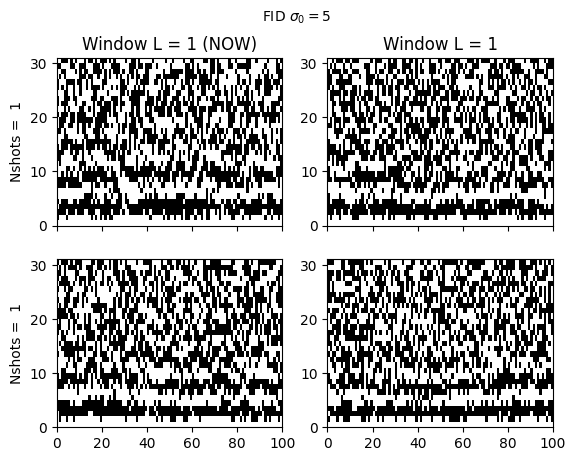

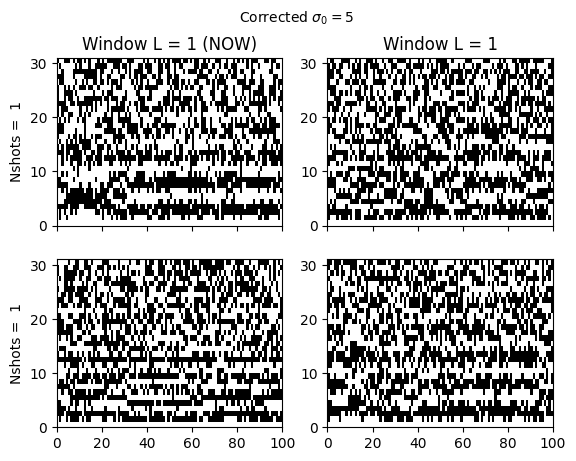

In [213]:

fig, ax = plt.subplots(len(Nshots),len(Ls),sharex=True)
fig.suptitle(r"FID $\sigma_0 ="+str(SIGMA)+"$", fontsize=10)
for i in range(len(Nshots)):
    for j in range(len(Ls)):
        ax[i,j].pcolormesh(bits_res[1,i,j,:,:].T, label = str(Ls[i]), cmap="binary_r")        
        #ax[i].plot(data[i][1], label = str(Ns[i]))
        #ax[i].text(0.02, 0.75, 'L = ' + str(Ns[i]), fontsize=12, transform=ax[i].transAxes)
        #ax[i].set_ylim(-3,3) 



for k in range(2):
    ax[k,0].set_ylabel('Nshots =  '+str(Nshots[k]))


for k in range(2):
    if k==0:
        ax[0,k].set_title('Window L = '+str(Ls[k])+" (NOW)")
    else:
        ax[0,k].set_title('Window L = '+str(Ls[k]))
#ax[0].set_xlim(0,3000)
#ax[0].set_title('Nshots = '+str(N_SHOTS))   


fig, ax = plt.subplots(len(Nshots),len(Ls),sharex=True)
for i in range(len(Nshots)):
    for j in range(len(Ls)):
        ax[i,j].pcolormesh(bits_res[0,i,j,:,:].T, label = str(Ls[i]), cmap="binary_r")        
        #ax[i].plot(data[i][1], label = str(Ns[i]))
        #ax[i].text(0.02, 0.75, 'L = ' + str(Ns[i]), fontsize=12, transform=ax[i].transAxes)
        #ax[i].set_ylim(-3,3) 



for k in range(2):
    ax[k,0].set_ylabel('Nshots =  '+str(Nshots[k]))


for k in range(2):
    if k==0:
        ax[0,k].set_title('Window L = '+str(Ls[k])+" (NOW)")
    else:
        ax[0,k].set_title('Window L = '+str(Ls[k]))
#ax[0].set_xlim(0,3000)
#ax[0].set_title('Nshots = '+str(N_SHOTS))   

#add super title
fig.suptitle(r"Corrected $\sigma_0 ="+str(SIGMA)+"$", fontsize=10)


IndexError: index 2 is out of bounds for axis 0 with size 2

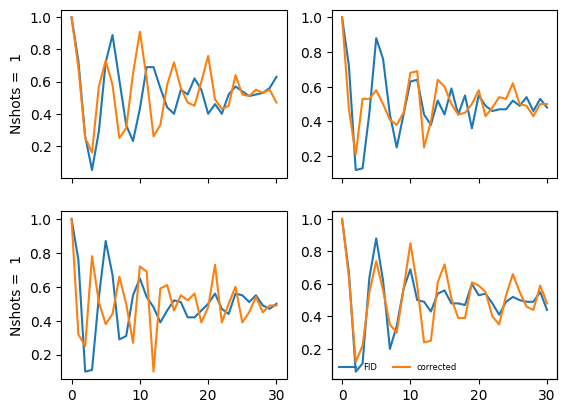

In [214]:
fig, ax = plt.subplots(len(Nshots),len(Ls),sharex=True)
for i in range(len(Nshots)):
    for j in range(len(Ls)):
        ax[i,j].plot(np.average(bits_res[1,i,j,:,:].T, axis=1))
        ax[i,j].plot(np.average(bits_res[0,i,j,:,:].T, axis=1))   

bx = ax[1,1].twinx()
bx.set_yticks([])
bx.plot([],[],label = "FID")
bx.plot([],[],label = "corrected")

bx.legend(frameon = False, ncol=2, loc = 'lower left', fontsize = 6)



for k in range(3):
    ax[k,0].set_ylabel('Nshots =  '+str(Nshots[k]))


for k in range(3):
    if k==0:
        ax[0,k].set_title('Window L = '+str(Ls[k])+" (NOW)")
    else:
        ax[0,k].set_title('Window L = '+str(Ls[k]))
#ax[0].set_xlim(0,3000)
#ax[0].set_title('Nshots = '+str(N_SHOTS))   
fig.suptitle(r"$\sigma_0 ="+str(SIGMA)+"$", fontsize=10)

[autoreload of noise_models failed: Traceback (most recent call last):
  File "/usr/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/usr/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/usr/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: __init__() requires a code object with 1 free vars, not 0
]


<Figure size 640x480 with 0 Axes>

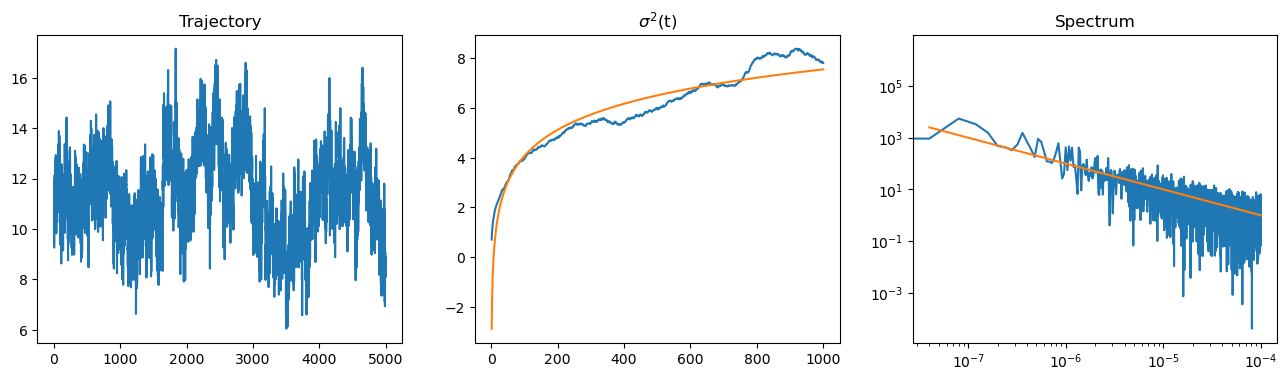

0.16839776218831876
-0.035786000971661014
-0.29671256321888223
0.6216219660505103
0.3454714211124545
-0.266795024454306
-0.35472699777798666
-0.551251514505405
0.9089046834598699
0.15443778406967096
-0.8976286240585447
-0.44901900343768725
0.33360263639349697
0.6609205437988065
-0.1067616199434232
0.4263312684249558
-0.11737368799187771
0.32609758836517994
-0.8137099947374453
-0.18673978470558025
50
0.16839776218831876
-0.035786000971661014
-0.29671256321888223
0.6216219660505103
0.3454714211124545
-0.266795024454306
-0.35472699777798666
-0.551251514505405
0.9089046834598699
0.15443778406967096
-0.8976286240585447
-0.44901900343768725
0.33360263639349697
0.6609205437988065
-0.1067616199434232
0.4263312684249558
-0.11737368799187771
0.32609758836517994
-0.8137099947374453
-0.18673978470558025
50
0.16839776218831876
-0.035786000971661014
-0.29671256321888223
0.6216219660505103
0.3454714211124545
-0.266795024454306
-0.35472699777798666
-0.551251514505405
0.9089046834598699
0.1544377840696

(2475000.0, 2775000.0)

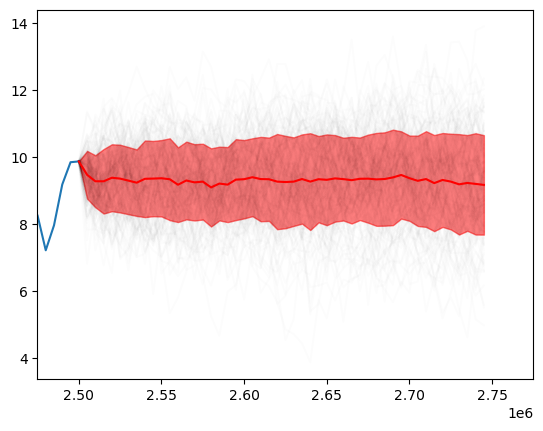

In [35]:
import noise_models as nm
import noise_models as nm
reload(nm)

plt.figure()
noise.get_abc(SHOT_TIME)
plt.figure()
N_TRAJECTORIES = 150
HORIZON = 50
TRAINING_SIZE = 500

times_training = np.arange(0, TRAINING_SIZE+1)*SHOT_TIME

times_predicting = np.arange(TRAINING_SIZE, TRAINING_SIZE + HORIZON)*SHOT_TIME
# copy object

trajectory_training_ou = noise.gen_trajectory(times_training)
shots = 100
fluctuators_xs = [fluctuator.x for fluctuator in noise.fluctuators]


xis = np.zeros((N_TRAJECTORIES, HORIZON))
for i in range(N_TRAJECTORIES):
    for n,fluctuator in enumerate(noise.fluctuators):
        fluctuator.x = fluctuators_xs[n] 
        print(fluctuator.x)
    noise.update(1e-99999)
        
    trajectory_predicting_ou = noise.gen_trajectory(times_predicting)
    print(len(trajectory_predicting_ou))
    xis[i] = trajectory_predicting_ou
    plt.plot(times_predicting, xis[i], "k", alpha=0.01)

plt.plot(times_training, trajectory_training_ou)


plt.plot(times_predicting, np.mean(xis, axis=0), "r")
plt.fill_between(times_predicting, np.mean(xis, axis=0) - np.std(xis, axis=0), np.mean(xis, axis=0) + np.std(xis, axis=0), color="r", alpha=0.5)
plt.xlim((TRAINING_SIZE-5)*SHOT_TIME, (TRAINING_SIZE+HORIZON+5)*SHOT_TIME)



0.531772860484058 1.6154420014496274 3.0065175326194895


/var/tmp/krzywda/ipykernel_63229/65156921.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(t, np.sqrt(a*np.log(b*t)))
/var/tmp/krzywda/ipykernel_63229/65156921.py:8: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(t, np.sqrt(a*np.log(b*t)))


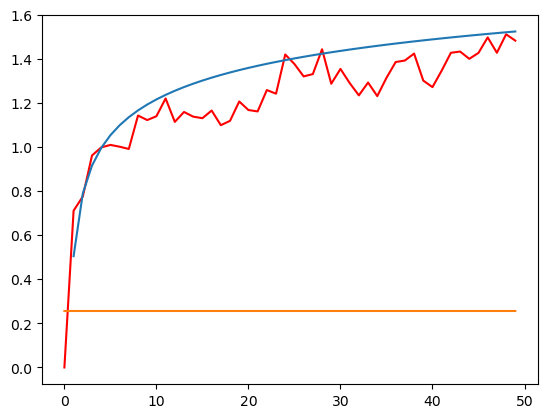

In [41]:

#noise.get_abc(SHOT_TIME)
plt.figure()
plt.plot(np.std(xis, axis=0), "r")
a,b,c = noise.abc
t = np.arange(0,50)
print(a,b,c)
sigs = [0]
plt.plot(t, np.sqrt(a*np.log(b*t)))
for k in t:
    sigs.append(a*np.log((np.exp((sigs[-1]**2-c)/a))+b))
plt.plot(t,sigs[1:])

In [25]:
b

0.3244891220437073

In [23]:
a*np.log((np.exp((sigs[-1]**2-c)/a))+b)

-0.20544326001575117

/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_120/1010595723.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(f, 1/f)


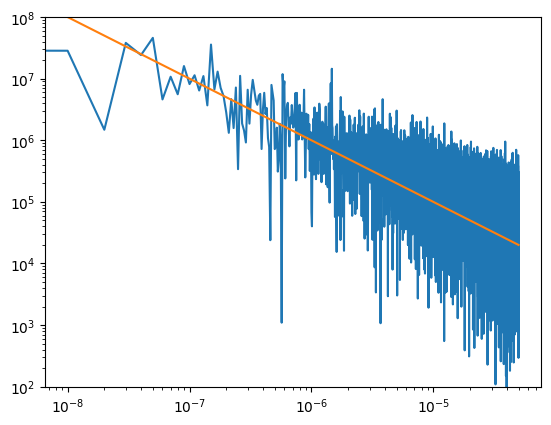

In [ ]:
#check 1/f specturm
f, Pxx = nm.get_spectrum(y, 1e4,1e8)
plt.figure()
plt.plot(f,Pxx)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e2,1e8 )
plt.plot(f, 1/f)



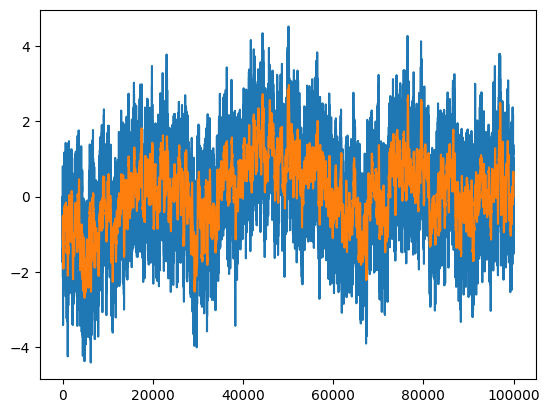

In [252]:
# Correlation function
def moving_average(x, w):
    y = []
    for k,_ in enumerate(x):
        if k==0:
            y.append(x[0])
        elif k<w:
            y.append(np.mean(x[:k]))
        else:
            y.append(np.mean(x[k-w:k]))
    return y


N = int(1e5)
times=  np.arange(N)*SHOT_TIME
y=  noise.gen_trajectory(times)
plt.plot(y)


L = 100
ym = moving_average(y,L)
plt.plot(ym)




In [182]:
ym

[-1.147095787385604,
 -1.147095787385604,
 -1.1531079556795336,
 -1.0464291939148467,
 -0.8459837804262157,
 -0.7167709163615797,
 -0.6285355226146591,
 -0.5325816637212575,
 -0.4467323051482735,
 -0.3891385951581634,
 -0.32857259274167794,
 -0.12850409770582027,
 0.05479534310493193,
 0.18828877220504814,
 0.30705665988130104,
 0.42333204293301224,
 0.47930775351257465,
 0.4955070300588001,
 0.5216925730468737,
 0.5699464264827376,
 0.6006604699376779,
 0.6016745786652544,
 0.5868009413595346,
 0.5573399408009289,
 0.48099937821369265,
 0.32931263992230264,
 0.3377971930627556,
 0.39098195846588724,
 0.3929715203748649,
 0.39412861613184125,
 0.3469157811983258,
 0.26696796411371804,
 0.23268687955746223,
 0.18092358384669366,
 0.11945897267777587,
 0.14111689013712758,
 0.04917657546741158,
 -0.004472508038088347,
 -0.002838003068163608,
 -0.02296523697369394,
 0.017100620239200358,
 0.07708056869879429,
 0.09880668841867844,
 0.19783427682997984,
 0.34531895568490417,
 0.51147172724

In [253]:
f, sxm = nm.get_spectrum(moving_average(y,L), 1e4,N*1e4)
f, sx = nm.get_spectrum(y, 1e4,N*1e4)

/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_55966/647327690.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(f,1/f/1e1)
/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_55966/647327690.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(f,1/f**2/1e8)


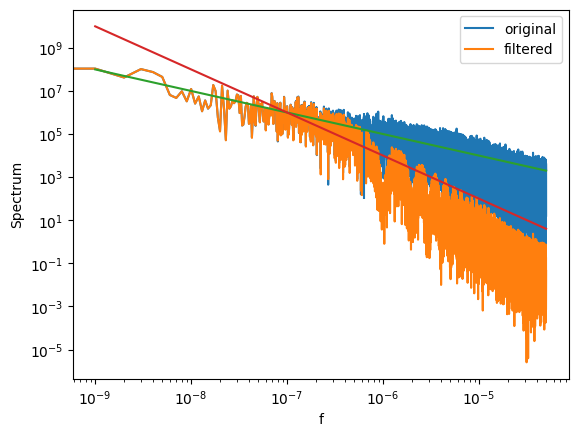

In [254]:

plt.plot(f, sx, label="original")
plt.plot(f, sxm, label="filtered")

plt.xlabel("f")
plt.ylabel("Spectrum")
tc = L*SHOT_TIME
plt.vlines(1/L/SHOT_TIME/np.pi, 1e2,1e6)
plt.plot(f,1/f/1e1)
plt.plot(f,1/f**2/1e8)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [255]:
sigmasm = []
sigmas = []
ym = np.array(ym)
y = np.array(y)

Nsig = 500
for k in range(Nsig):
    if k>0:
        sigmasm.append(np.var(ym[k:]-ym[:-k]))
        sigmas.append(np.var(y[k:]-y[:-k]))


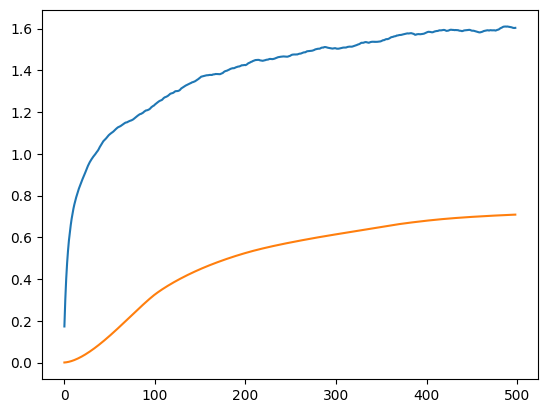

In [256]:
plt.plot(sigmas)
plt.plot(sigmasm)

/Users/krzywdaja/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([0.76801315, 0.00542826, 1.        ])

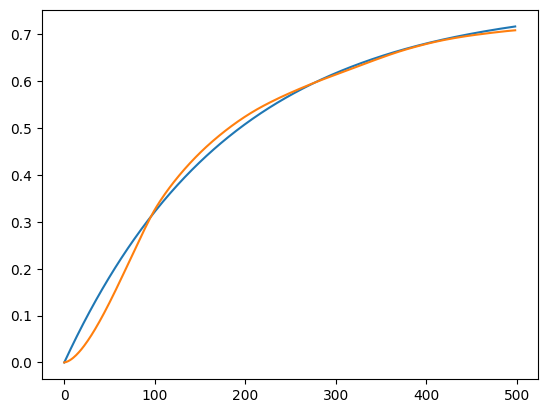

In [258]:
# curve fitting
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*(1-(np.exp(-b*x)))


popt, pcov = curve_fit(func, np.arange(Nsig-1), sigmasm)
plt.plot(func(np.arange(Nsig-1), *popt))
plt.plot(sigmasm)
popt 

In [260]:
1/L/SHOT_TIME/np.pi

6.366197723675813e-07

In [262]:
popt[1]/1e4

5.428264730076344e-07